# Model definition, training and model evaluation

In [1]:
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
# The code was removed by Watson Studio for sharing.

,capacity_mw,generation,year,fuel_count,0,1,2,3,4,5,...,125,126,127,128,129,130,131,132,133,134
0,-0.324290,89.132072,2014,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,-0.324290,89.132072,2014,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.597264,1650.593994,2014,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.597264,1650.593994,2014,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.792095,1980.712769,2014,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Train and test splits

For train and evaluation model was created train and test dataset that will be used by our models.

In [3]:
X = df.iloc[:, np.where(df.columns != 'generation')[0]]
y = df['generation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

## Baseline

Let's create a baseline to compare models with null model. First for all, it needs to create `y` baseline.

In [4]:
y_baseline = np.repeat(df['generation'].mean(), y_test.shape[0])

Train and test datasets were created so I trained baseline model which shows very bad result.

In [5]:
fit = LinearRegression().fit(X_train, y_baseline)
fit.score(X_test, y_test)

-1.2157817111280167e-05

In [6]:
fit.coef_[1:10]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

## OLS

Let's create another OLS. It shows quite good result.

In [7]:
fit = LinearRegression().fit(X_train, y_train)

In [8]:
fit.score(X_test, y_test)

-1.1802758679164262e+17

Coefficient for model is too high so model probably overffited.

In [9]:
fit.coef_[1:10]

array([ -2.57119146e+01,  -3.11321466e+02,   1.48689155e+15,
         1.48689155e+15,   1.48689155e+15,   1.48689155e+15,
         1.48689155e+15,   1.48689155e+15,   1.48689155e+15])

## XGBoost

XGboost shows better result than baseline significatly. It uses default parameters because XGBoost require a lot time to train

In [10]:
%%time
import xgboost as xgb

fit = xgb.XGBRegressor().fit(X_train, y_train)
fit.score(X_test, y_test)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


CPU times: user 2min 26s, sys: 16.1 s, total: 2min 43s
Wall time: 2min 44s


In [11]:
fit.score(X_test, y_test)

0.88622506531736489

In [12]:
from xgboost import plot_importance
plot_importance(fit)

## Tensorflow

According to the task one of the model should use deep learning. I used Tensorflow and Keras because it easy to use. First of all I normalized data for current model. Also I dropped year and fuel count because they descrese model qualitity.

In [13]:
from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler(copy=True)
y_scaler.fit(y_train[:,np.newaxis])
y_train_scaled = y_scaler.transform(y_train[:,np.newaxis])
X_train_scaled = X_train.drop(['year', 'fuel_count'],axis=1)

y_scaler_test = MinMaxScaler(copy=True)
y_scaler_test.fit(y_test[:,np.newaxis])
y_test_scaled = y_scaler_test.transform(y_test[:,np.newaxis])

X_test_trimmed = X_test.drop(['year', 'fuel_count'],axis=1)

Architecture of neural network consists of 3 Dense layers. MomentumOptimizer was chosen as optimizer for neural network. Metric of quality and loss was chosen mean squared error. First and second layer consists of relu activation functions, last layer consist of linear activation function because it works the best for regression problem.

In [14]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers.normalization import BatchNormalization

arch = Sequential()
arch.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))
arch.add(Dense(64, activation='relu'))
arch.add(Dense(1, activation='linear'))

optimizer = tf.train.MomentumOptimizer(learning_rate=0.001, momentum=0.9)

arch.compile(optimizer=optimizer, metrics=['mse'], loss=tf.losses.mean_squared_error)

Using TensorFlow backend.


Architecture was built so we have architecture which are printented below:

In [15]:
arch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                4832      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 7,009
Trainable params: 7,009
Non-trainable params: 0
_________________________________________________________________


So model is ready to fit with validation split **50** percent and epochs count **10**.

In [16]:
fit = arch.fit(X_train_scaled, y_train_scaled, epochs=50, validation_split=0.3)

Train on 26399 samples, validate on 11315 samples
Epoch 1/50
26399/26399 [==============================] - 3s 100us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 2/50
26399/26399 [==============================] - 3s 97us/step - loss: 8.2360e-04 - mean_squared_error: 8.2360e-04 - val_loss: 6.5614e-04 - val_mean_squared_error: 6.5614e-04
Epoch 3/50
26399/26399 [==============================] - 3s 100us/step - loss: 5.9484e-04 - mean_squared_error: 5.9484e-04 - val_loss: 5.1973e-04 - val_mean_squared_error: 5.1973e-04
Epoch 4/50
26399/26399 [==============================] - 3s 96us/step - loss: 4.9885e-04 - mean_squared_error: 4.9885e-04 - val_loss: 4.4773e-04 - val_mean_squared_error: 4.4773e-04
Epoch 5/50
26399/26399 [==============================] - 3s 99us/step - loss: 4.4374e-04 - mean_squared_error: 4.4374e-04 - val_loss: 4.0419e-04 - val_mean_squared_error: 4.0419e-04
Epoch 6/50
26399/26399 [=========================

In [17]:
from sklearn.metrics import r2_score
r2_score(arch.predict(X_test_trimmed), y_test_scaled)


0.75384983763460922

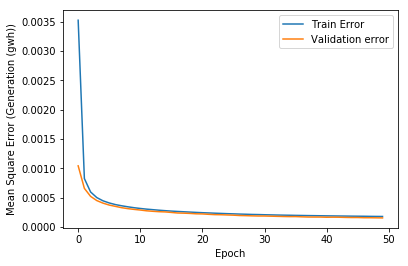

In [18]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error (Generation (gwh))')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label='Validation error')
  plt.legend()


  plt.show()

plot_history(fit)